In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import skimage.color
import skimage.filters
import skimage.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization 
from keras.optimizers import adam_v2, rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator

**Storing classification images into a CSV file**

To mimic the training dataset available in the dataset on kaggle, we manually classified the dataset and then stored the data in a csv file


In [ ]:
'''categories = []
filenames = os.listdir("drive/MyDrive/final_data/yes")
for filename in filenames:
  categories.append(1)
filenames2 = os.listdir("drive/MyDrive/final_data/no")
for filename in filenames2:
  categories.append(0)
filenames.extend(filenames2)
print(len(filenames),len(categories))
df = pd.DataFrame({
    'filename': filenames,
    'category': categories})
df.to_csv('final_image_classes.csv')
'''

3140 3140


In [ ]:
#!cp -a drive/MyDrive/final_data/no/. drive/MyDrive/final_data/total/
#!cp -a drive/MyDrive/final_data/yes/. drive/MyDrive/final_data/total/ 

**Data Loading in 2 Phase**

Phase 1 is where we load the filenames in csv weith its according class. As our dataset was not having classes we had to manually classify the images to folders

Phase 2 is where we use the csv file to load images from the image pool.

**Phase 1**


In [ ]:
df = pd.read_csv('drive/MyDrive/final_image_classes.csv')
df['category'] = df['category'].astype(str)
df.head()
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

**Phase 2**

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "drive/MyDrive/final_data/total/",
    x_col='filename',
    #color_mode = 'grayscale',
    y_col='category',
    target_size=(256,256),
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "drive/MyDrive/final_data/total/", 
    x_col='filename',
    y_col='category',
    shuffle=False,
    target_size=(256,256),
    class_mode='categorical')


Found 2512 validated image filenames belonging to 2 classes.
Found 628 validated image filenames belonging to 2 classes.


**Model Preperation**

For this CNN model we have kept the pool size fixed to (2,2)
We have used softmax function at the final layer for two outputs for observing the probability ofboth the classes.

In [ ]:

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(256,256,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
convolutio
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

In [ ]:
history = model.fit(
    train_generator, 
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20
79/79 [==============================] - 1294s 16s/step - loss: 0.8433 - accuracy: 0.5975 - val_loss: 0.7843 - val_accuracy: 0.7182
Epoch 2/20
79/79 [==============================] - 75s 954ms/step - loss: 0.7102 - accuracy: 0.6708 - val_loss: 0.5995 - val_accuracy: 0.7134
Epoch 3/20
79/79 [==============================] - 74s 938ms/step - loss: 0.6117 - accuracy: 0.7070 - val_loss: 0.6715 - val_accuracy: 0.7150
Epoch 4/20
79/79 [==============================] - 74s 942ms/step - loss: 0.5616 - accuracy: 0.7560 - val_loss: 0.5855 - val_accuracy: 0.7166
Epoch 5/20
79/79 [==============================] - 74s 938ms/step - loss: 0.5109 - accuracy: 0.7866 - val_loss: 0.5402 - val_accuracy: 0.7213
Epoch 6/20
79/79 [==============================] - 74s 939ms/step - loss: 0.5271 - accuracy: 0.7814 - val_loss: 0.5131 - val_accuracy: 0.7150
Epoch 7/20
79/79 [==============================] - 74s 937ms/step - loss: 0.4759 - accuracy: 0.8069 - val_loss: 0.5633 - val_accuracy: 0.7627

**Accuracy and Loss Trend during training**

According to the graphs, and the output after each epoch, it can be observed that although over accuracy and loss are gradually going towards the right direction, the validation data is fluctuating a lot.


Accuracy  &  Validation Accuracy



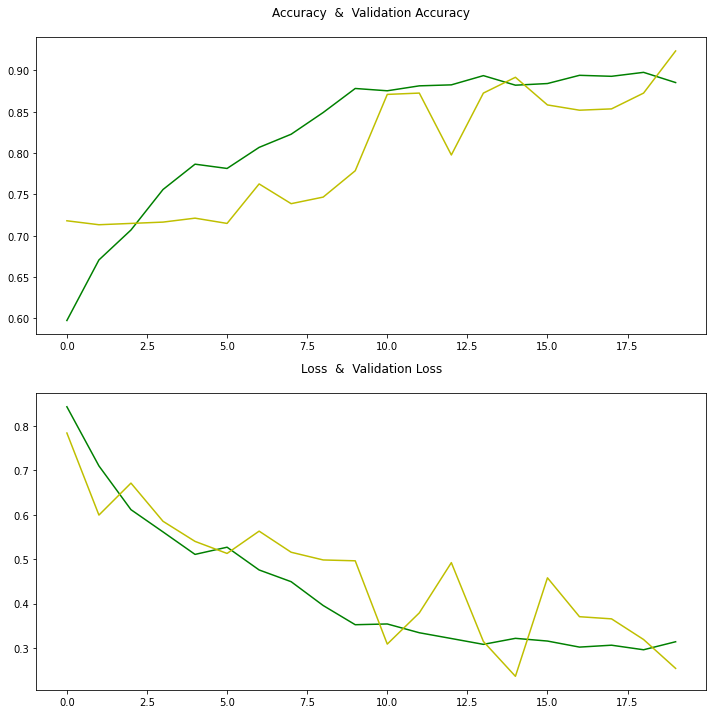

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
print("Accuracy  &  Validation Accuracy\n")
ax1.title.set_text("Accuracy  &  Validation Accuracy\n")
ax1.plot(history.history['accuracy'], color='g', label="Training accuracy")
ax1.plot(history.history['val_accuracy'], color='y',label="Validation accuracy")
ax2.title.set_text("Loss  &  Validation Loss\n")
ax2.plot(history.history['loss'], color='g', label="Training loss")
ax2.plot(history.history['val_loss'], color='y', label="validation loss")
plt.show()

**Storing Weights**

To avoid training the model everytime to show the performance and outputs, we have saved the model in h5 format. The training this particular model takes 37 minutes.

In [ ]:
model.save_weights('final_model_weights.h5')

In [ ]:
model.load_weights('drive/MyDrive/final_model_weights.h5')

In [ ]:
out_p = model.predict(validation_generator)

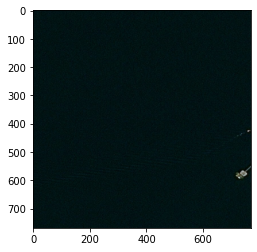

Actual:  1  Prediction:  [0 1]


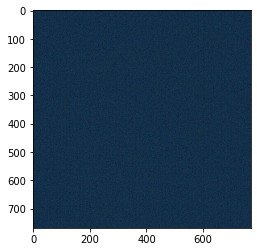

Actual:  0  Prediction:  [1 0]


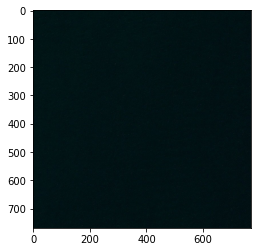

Actual:  0  Prediction:  [1 0]


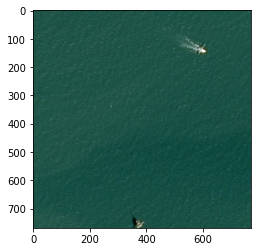

Actual:  1  Prediction:  [1 0]


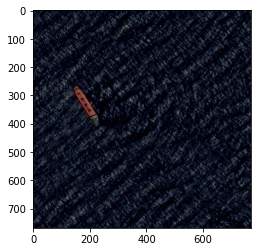

Actual:  1  Prediction:  [1 0]


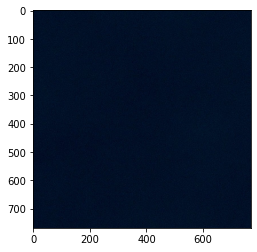

Actual:  0  Prediction:  [1 0]


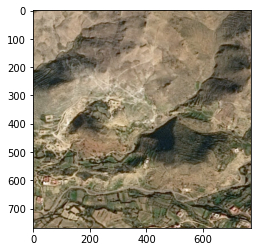

Actual:  0  Prediction:  [1 0]


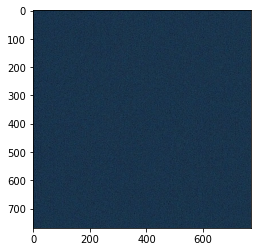

Actual:  0  Prediction:  [1 0]


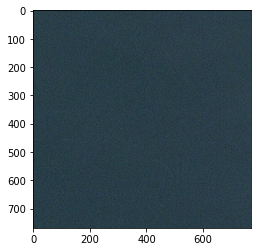

Actual:  0  Prediction:  [1 0]


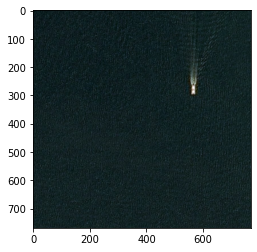

Actual:  1  Prediction:  [0 1]


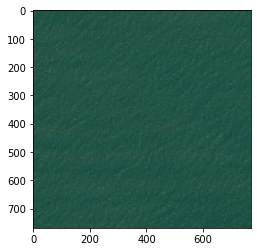

Actual:  0  Prediction:  [1 0]


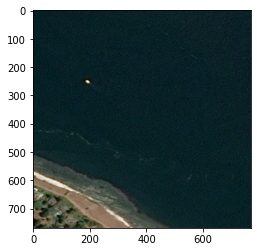

Actual:  0  Prediction:  [0 1]


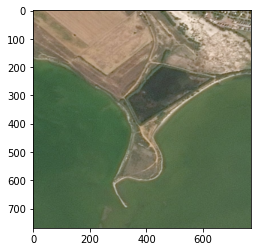

Actual:  0  Prediction:  [1 0]


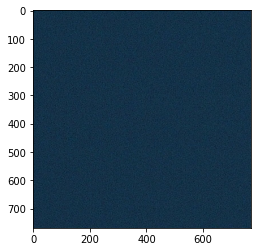

Actual:  0  Prediction:  [1 0]


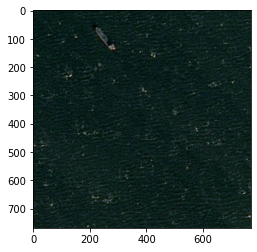

Actual:  1  Prediction:  [1 0]


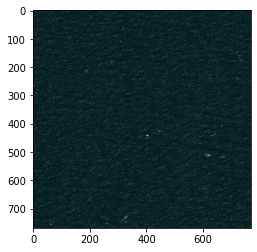

Actual:  0  Prediction:  [1 0]


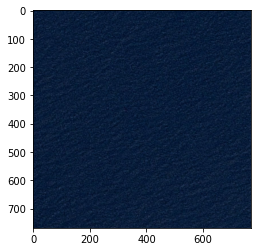

Actual:  0  Prediction:  [1 0]


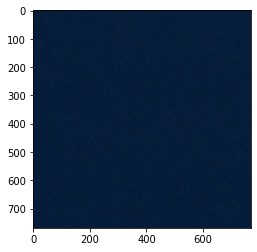

Actual:  0  Prediction:  [1 0]


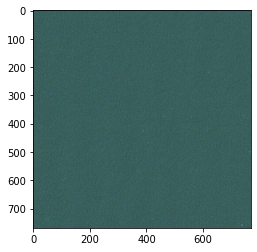

Actual:  0  Prediction:  [1 0]


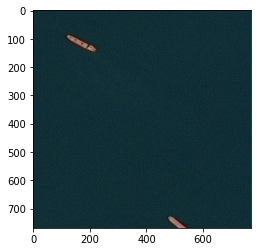

Actual:  1  Prediction:  [0 1]


In [ ]:
out_p = out_p > 0.5
out_p = out_p.astype(int)
import matplotlib.image as mpimg
for i in range(60,80):
  img = mpimg.imread('drive/MyDrive/final_data/total/'+validate_df['filename'][i])
  imgplot = plt.imshow(img)
  plt.show()
  print("Actual: ",validate_df['category'][i]," Prediction: ",out_p[i])

**Visual representation of filters applied in the model**

32


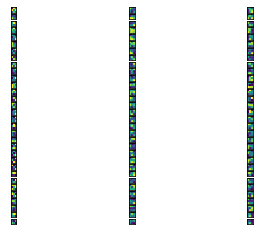

64


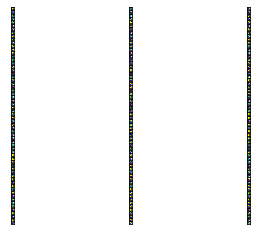

128


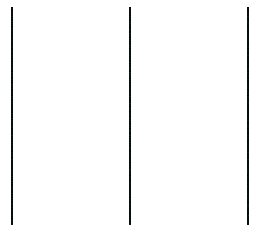

In [ ]:
#Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        # print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()